In [16]:
import gym
from multiprocessing import Process, Queue
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
class RL_Process(Process):
    def __init__(self, *args, env: gym.Env = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.recv_messages = Queue()
        self.running = False
        self.message_handlers = {'quit': self.quit}
        self.env = env
        
    def create_networks(self):
        import tensorflow as tf
        self.tf = tf
        self.actor = tf.keras.Sequential([
#             tf.keras.layers.Conv2D(filters = 16, kernel_size = 7, strides = 4, input_shape = self.env.observation_space.shape),
#             tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dense(self.env.action_space.n)
        ])
        self.critic = tf.keras.Sequential([
#             tf.keras.layers.Conv2D(filters = 16, kernel_size = 7, strides = 4, input_shape = self.env.observation_space.shape),
#             tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dense(1)
        ])
        self.optimizer = tf.keras.optimizers.Adam()
        obs = self.env.reset()
        obs = np.expand_dims(obs, 0)
        self.actor(obs)
        self.critic(obs)
        
    def quit(self, message):
        print("Received quit message")
        self.running = False
        
    def run(self):
        self.running = True
        self.create_networks()
        while self.running:
            if not self.recv_messages.empty():
                message = self.recv_messages.get()
                message_id = message['id']
                if message_id in self.message_handlers:
                    self.message_handlers[message_id](message)
                else:
                    raise ValueError(f"Invalid message received: {message}")
        

In [23]:
def discount_rewards(rewards, gamma, standardized: bool = False):
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(len(rewards))):                   
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
    if standardized:
        mean = np.mean(discounted_rewards)
        discounted_rewards -= mean
        standard_deviation = np.std(discounted_rewards)
        discounted_rewards/=(standard_deviation + np.finfo(np.float32).eps) 
    return discounted_rewards

class Worker_Process(RL_Process):
    def __init__(self, *args, batch_size = 30, nn_process_queue = None, worker_id = 0, max_timesteps = 100, gamma = 0.95, **kwargs):
        super().__init__(*args, **kwargs)
        self.gamma = gamma
        self.batch_size = batch_size
        self.max_timesteps = max_timesteps
        self.nn_process_queue = nn_process_queue
        self.worker_id = worker_id
        self.message_handlers.update(train = self.train_batch) # same as next line
        self.message_handlers['train'] = self.train_batch
        self.message_handlers['weights'] = self.set_weights
    
    def create_networks(self):
        super().create_networks()
        seed = hash(self.worker_id)
        self.env.seed(seed)
        self.tf.random.set_seed(seed)
        np.random.seed(seed)
        
    def send_message(self, message_id, **kwargs):
        message = dict(id = message_id, **kwargs)
        self.nn_process_queue.put(message)
    
    def choose_action(self, obs):
        obs = np.expand_dims(obs, axis = 0)
        logits = self.actor.predict(obs)
        probablity_weights = self.tf.nn.softmax(logits = logits).numpy()[0]
        action = np.random.choice(env.action_space.n, 1, p = probablity_weights)[0]
        return action

    def estimate_value(self, obs):
        obs = np.expand_dims(obs, axis = 0)
        value = self.critic.predict(obs)
        return value
   
    def critic_loss(self, observations, rewards):
        huber_loss = self.tf.keras.losses.Huber(reduction=self.tf.keras.losses.Reduction.SUM)
        values = self.critic(observations)
        loss = huber_loss(values, rewards)
        return loss

    def actor_loss(self, actions, observations, values, rewards):
        advantage = rewards - values
        logits = self.actor(observations)
        negative_log_prob = self.tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = actions)
        loss = self.tf.reduce_mean(negative_log_prob*advantage)
        return loss
    
    def run_episode(self):
        obs = self.env.reset()
        observations = []
        values = []
        rewards = []
        actions = []
        for t in range(self.max_timesteps):
            action = self.choose_action(obs)
            value = self.estimate_value(obs)
            observations.append(obs)
            values.append(value)
            actions.append(action)
            obs, reward, done, info = self.env.step(action)
            rewards.append(reward)
            if done:
                break
        return observations, actions, values, rewards
    
    def run_batch(self, episodes, show_progress = False):
        batch_observations = []
        batch_values = []
        batch_rewards = []
        batch_actions = []
        with tqdm(total = episodes, desc = 'Batch Progress', disable = not show_progress) as progress_bar:
            for episode in range(episodes):
                observations, actions, values, rewards = self.run_episode()
                progress_bar.set_postfix_str(f'Episode Reward: {sum(rewards)}')
                progress_bar.update()
                batch_observations.extend(observations)
                batch_actions.extend(actions)
                batch_values.extend(values)
                rewards = discount_rewards(rewards, gamma = self.gamma, standardized = False)
                batch_rewards.extend(rewards)
        return batch_observations, batch_actions, batch_values, batch_rewards
    
    def train_step(self, observations, actions, values, rewards):
        values = np.array(values)
        rewards = np.array(rewards)
        observations = np.array(observations)
        # Step 1. Train actor using critic
        with self.tf.GradientTape() as tape:
            loss = self.actor_loss(actions, observations, values, rewards)
            actor_gradients = tape.gradient(loss, self.actor.trainable_variables)
            self.optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))
 
        # Step 2. Train critic
        with self.tf.GradientTape() as tape:
            loss = self.critic_loss(observations, rewards)
            critic_gradients = tape.gradient(loss, self.critic.trainable_variables)
            self.optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))
        
        return actor_gradients, critic_gradients
    
    def train_batch(self, message):
        episode_assignment = message['episode_assignment']
        mean_values = []
        mean_rewards = []
        episodes = []
        for episode in range(episode_assignment):
            observations, actions, values, rewards = self.run_batch(1, show_progress = False)
            episodes.append(episode)
            mean_values.append(np.mean(values))
            mean_rewards.append(np.mean(rewards))
            self.send_message('reward', reward = mean_rewards[-1], worker_id = self.worker_id, episode = episode)
            actor_gradients, critic_gradients = self.train_step(observations, actions, values, rewards)
            self.send_message('gradients', actor_gradients = actor_gradients, critic_gradients = critic_gradients)
        self.send_message('complete', worker_id = self.worker_id, episodes_complete = episode_assignment)
        
    def set_weights(self, message):
        self.actor.set_weights(message['actor_weights'])
        self.critic.set_weights(message['critic_weights'])

In [33]:
from IPython.display import clear_output

class NN_Process(RL_Process):
    def __init__(self, *args, max_workers = 4, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_workers = max_workers
        self.workers = [Worker_Process(nn_process_queue=self.recv_messages, worker_id=i, env = self.env) for i in range(max_workers)]
        self.worker_rewards = {
            worker.worker_id:dict(episodes = [], rewards = []) for worker in self.workers
        }
        self.worker_plot_styles = {
            worker.worker_id: f"{'rb'[i%2]}." for i, worker in enumerate(self.workers)
        }
        self.message_handlers['gradients'] = self.apply_gradients
        self.message_handlers['complete'] = self.worker_complete
        self.message_handlers['start_training'] = self.setup_worker_assignments
        self.message_handlers['reward'] = self.reward_update
    
    def reward_update(self, message):
        self.worker_rewards[message['worker_id']]['rewards'].append(message['reward'])
        self.worker_rewards[message['worker_id']]['episodes'].append(message['episode'])
        clear_output(wait = True)
        xs = []
        ys = []
        for worker_id, worker_metrics in self.worker_rewards.items():
            plt.plot(worker_metrics['episodes'], worker_metrics['rewards'], self.worker_plot_styles[worker_id])
            xs.extend(worker_metrics['episodes'])
            ys.extend(worker_metrics['rewards'])
        if len(xs) > len(self.workers):
            poly = np.polyfit(xs, ys, 1)
            plt.plot((0, max(xs)), (poly[1], poly[1] + max(xs)*poly[0]), 'k-')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.show()
    
    def apply_gradients(self, message):
        self.optimizer.apply_gradients(zip(message['actor_gradients'], self.actor.trainable_variables))
        self.optimizer.apply_gradients(zip(message['critic_gradients'], self.critic.trainable_variables))
        
    def send_message(self, worker_id, message_id, **kwargs):
        message = dict(id = message_id, **kwargs)
        if worker_id < self.max_workers:
            self.workers[worker_id].recv_messages.put(message)
        else:
            raise ValueError(f'Worker ID {worker_id} is invalid')
        
    def worker_complete(self, message):
        worker_id = message['worker_id']
        episodes_complete = message['episodes_complete']
        self.pending_episodes -= episodes_complete
        if self.total_episodes > 0:
            self.assign_work(worker_id)
        else:
            self.send_message(worker_id, 'quit')
            if self.pending_episodes <= 0:
                self.running = False
            
    def start_training(self, total_episodes = 100, episodes_per_assignment = 50, max_steps_per_episode = 500):
        for worker in self.workers:
            if not worker.is_alive():
                worker.start()
        self.total_episodes = total_episodes
        self.episodes_per_assignment = episodes_per_assignment
        self.start()
        self.recv_messages.put(dict(id = 'start_training', total_episodes = total_episodes, episodes_per_assignment = episodes_per_assignment, 
                                    max_steps_per_episode = max_steps_per_episode))
        
    def setup_worker_assignments(self, message):
        self.total_episodes = message['total_episodes']
        self.pending_episodes = 0
        self.episodes_per_assignment = message['episodes_per_assignment']
        for worker in self.workers:
            self.assign_work(worker.worker_id)
            
    def assign_work(self, worker_id):
        episode_assignment = min(self.episodes_per_assignment, self.total_episodes)
        if episode_assignment > 0:
            self.total_episodes -= episode_assignment
            self.pending_episodes += episode_assignment
            self.send_weights(worker_id)
            self.send_message(worker_id, 'train', episode_assignment = episode_assignment)
        
    def send_weights(self, worker_id):
        self.send_message(worker_id, 'weights', actor_weights = self.actor.get_weights(), 
                          critic_weights = self.critic.get_weights())

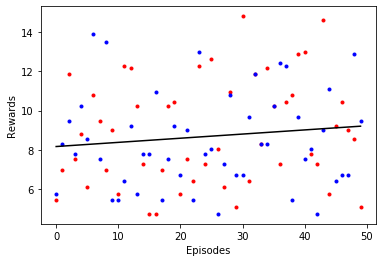

Received quit message


In [34]:
env = gym.make('CartPole-v0')
nn_manager = NN_Process(env = env, max_workers = 2)
nn_manager.start_training()